In [1]:
import pandas as pd

import wmfdata as wmf
from wmfdata.utils import (
    insert_code_toggle,
    pd_display_all,
    print_err
)

from trending_articles import LISTS as countries

In [65]:
wmf.charting.set_mpl_style()

In [2]:
insert_code_toggle()

In [20]:
def sql_tuple(i):
    """
    Making an SQL 'tuple', for use in an IN clause, is hard. Doing it manually using 
    `", ".join` requires a lot of messing around with quote marks and escaping. Using the
    string representation of a Python tuple *almost* works, but fails when there's just
    one element, because SQL doesn't accept the trailing comma that Python uses.
    What we really want is the string representation of a Python list, but using parentheses
    instead of brackets. This function turns an iterable into just that.
    """
    # Transform other iterables into lists, raising errors for non-iterables
    if type(i) != list:
        i = [x for x in i]
    
    # Don't return empty SQL tuples, since they cause syntax errors 
    if len(i) == 0:
        return None

    list_repr = repr(i)

    return "(" + list_repr[1:-1] + ")"

PRESTO_PARTITION_DATE = "CONCAT(CAST(year AS VARCHAR), '-', LPAD(CAST(month AS VARCHAR), 2, '0'), '-', LPAD(CAST(day AS VARCHAR), 2, '0'))"

today = pd.Timestamp.now().strftime("%Y-%m-%d")
yesterday = (pd.Timestamp.now() - pd.DateOffset(days=1)).strftime("%Y-%m-%d")

The experiment was released to the KaiOS store on 8 April, in version 1.6.0 of the app. On 5 May, we [fixed](https://www.mediawiki.org/w/index.php?title=Wikipedia_for_KaiOS/engagement1&diff=4563366&oldid=4520262) a vandalization of our config that prevent the recommendations from being shown. Since then, has the experiment and its data collection been running correctly?

In [13]:
experiment_uniques = wmf.presto.run(f"""
WITH refined AS (
  SELECT
    CAST(FROM_ISO8601_TIMESTAMP(meta.dt) AS DATE) AS date,
    event.user_id AS user_id,
    geocoded_data['country'] AS country,
    REDUCE(
      event.tests, 
      NULL, 
      (i, x) -> IF(x.name = '2021-KaiOS-app-homepage-content-suggestions', x."group", i),
      x -> x
    ) AS experiment_group
  FROM event.inukapageview
  WHERE
    geocoded_data['country'] IN ('Nigeria', 'Pakistan', 'Tanzania', 'Uganda')
    AND {PRESTO_PARTITION_DATE} BETWEEN '2021-05-06' AND '{today}'
    AND event.app_version = '1.6.0'
    AND event.is_production
), uniques AS (
  SELECT
    ARBITRARY(country) AS country,
    ARBITRARY(experiment_group) AS experiment_group
  FROM refined
  GROUP BY
    user_id
)
SELECT
  country,
  experiment_group,
  COUNT(*) AS devices
FROM uniques
GROUP BY
  country,
  experiment_group
ORDER BY
  country,
  experiment_group
""")

Based on [my power analysis](T271316#6893769), we expected to accumulate about 12,000 devices as experiment participants over a 6 week experiment.

So far, in roughly 20 days, we have accumulated about 17,400, so we seem to be well ahead of schedule. 

Moreover, these numbers meet two other expectations: the users are split pretty evenly between the two groups, and all users from our four participating countries are recorded as being in one of the two groups. 

In [15]:
pd.pivot_table(experiment_uniques, index="country", columns="experiment_group", aggfunc="sum", margins=True)

devices                         
experiment_group control trending-articles    All
country                                          
Nigeria             1372              1336   2708
Pakistan            3977              3875   7852
Tanzania            2251              2262   4513
Uganda              1191              1141   2332
All                 8791              8614  17405

In [22]:
# Have any of these uniques "crossed oved" between countries or experiment groups?
crossover_uniques = wmf.presto.run(f"""
WITH refined AS (
  SELECT
    CAST(FROM_ISO8601_TIMESTAMP(meta.dt) AS DATE) AS date,
    event.user_id AS user_id,
    geocoded_data['country'] AS country,
    REDUCE(
      event.tests, 
      NULL, 
      (i, x) -> IF(x.name = '2021-KaiOS-app-homepage-content-suggestions', x."group", i),
      x -> x
    ) AS experiment_group
  FROM event.inukapageview
  WHERE
    geocoded_data['country'] IN ('Nigeria', 'Pakistan', 'Tanzania', 'Uganda')
    AND {PRESTO_PARTITION_DATE} BETWEEN '2021-05-06' AND '{today}'
    AND event.app_version = '1.6.0'
    AND event.is_production
)
SELECT
    user_id,
    SET_AGG(country) AS distinct_countries,
    SET_AGG(experiment_group) AS distinct_groups
FROM refined
GROUP BY user_id
HAVING (
    COUNT(DISTINCT country) > 1
    OR COUNT(DISTINCT experiment_group) > 1
)
""")

None of these users was recorded in more than one country (which should be extremely rare) or in both experiment groups (which should never occur).

In [24]:
crossover_uniques.assign(
    user_id=lambda df: df["user_id"].str.slice_replace(0, 16, repl="X"*16)
)

,user_id,distinct_countries,distinct_groups


We intentionally do not track the names of the pages read together with the user ID, so we cannot check the groupwise reading patterns to verify that the users in the trending articles group are actually seeing the recommendations.

However, we do track the aggregate number of views to specific pages by various client _types_, so we can check the overall reading patterns of KaiOS app users in these countries to verify that there is some increase in pageviews to top recommended articles.

In [51]:
top_recommended_articles = (
    pd.read_csv("trending_articles.csv", parse_dates=["date"])
    .query(f"date >= '2021-05-01' & date < '{yesterday}' & rank == 1 & country != 'IN'")
    .reset_index(drop=True)
    [["date", "country", "article"]]
    .rename({
        "date": "trending_date",
    }, axis="columns")
    .assign(recommended_date=lambda df: df["trending_date"] + pd.DateOffset(days=1))
)

In [52]:
top_recommended_articles

,trending_date,country,article,recommended_date
0,2021-05-01,NG,Invincible_(TV_series),2021-05-02
1,2021-05-01,PK,International_Workers'_Day,2021-05-02
2,2021-05-01,TZ,Without_Remorse_(film),2021-05-02
3,2021-05-01,UG,Mortal_Kombat_(2021_film),2021-05-02
4,2021-05-02,NG,List_of_cities_in_Germany_by_population,2021-05-03
...,...,...,...,...
91,2021-05-23,UG,Premier_League,2021-05-24
92,2021-05-24,NG,List_of_states_and_territories_of_the_United_S...,2021-05-25
93,2021-05-24,PK,Pakistan,2021-05-25
94,2021-05-24,TZ,Mount_Nyiragongo,2021-05-25


In [45]:
relevant_pages = top_recommended_articles["article"].pipe(sql_tuple)

relevant_views = wmf.spark.run(f"""
SELECT
    DATE(CONCAT_WS('-', year, LPAD(CAST(month AS STRING), 2, '0'), LPAD(CAST(day AS STRING), 2, '0'))) AS `date`,
    country_code AS country,
    page_title AS article,
    SUM(view_count) AS views,
    SUM(IF(user_agent_map['os_family'] = 'KaiOS' AND access_method = 'mobile app', view_count, 0)) AS KaiOS_views
FROM wmf.pageview_hourly
WHERE
    page_title IN {relevant_pages}
    AND country_code IN ('NG', 'PK', 'TZ', 'UG')
    AND agent_type = 'user'
    AND project = 'en.wikipedia'
    AND year = 2021
    AND month >= 5
GROUP BY
    page_title,
    country_code,
    year,
    month,
    day
""")

PySpark executors will use /usr/lib/anaconda-wmf/bin/python3.


In [62]:
trending_date_relevant_views = (
    relevant_views
    .rename({
        "views": "trending_date_views", 
        "KaiOS_views": "KaiOS_trending_date_views",
        "date": "trending_date"
    }, axis="columns")
    .assign(trending_date=lambda df: pd.to_datetime(df["trending_date"]))
)

top_recommended_articles = pd.merge(
    top_recommended_articles,
    trending_date_relevant_views,
    how="left"
)

recommended_date_relevant_views = (
    relevant_views
    .rename({
        "views": "recommended_date_views", 
        "KaiOS_views": "KaiOS_recommended_date_views",
        "date": "recommended_date"
    }, axis="columns")
    .assign(recommended_date=lambda df: pd.to_datetime(df["recommended_date"]))
)

top_recommended_articles = (
    pd.merge(
        top_recommended_articles,
        recommended_date_relevant_views,
        how="left"
    ).assign(
        KaiOS_recommended_date_views_increase=
            lambda df: df["KaiOS_recommended_date_views"] - df["KaiOS_trending_date_views"]
    )
)

Starting on 5 May, when we fixed the configuration issue, most top-recommended articles see a substantial increase in KaiOS app views on the day they are recommended. This makes clear that the app users in the trending articles group are seeing the recommendations, and our experimental set-up is working as intended.

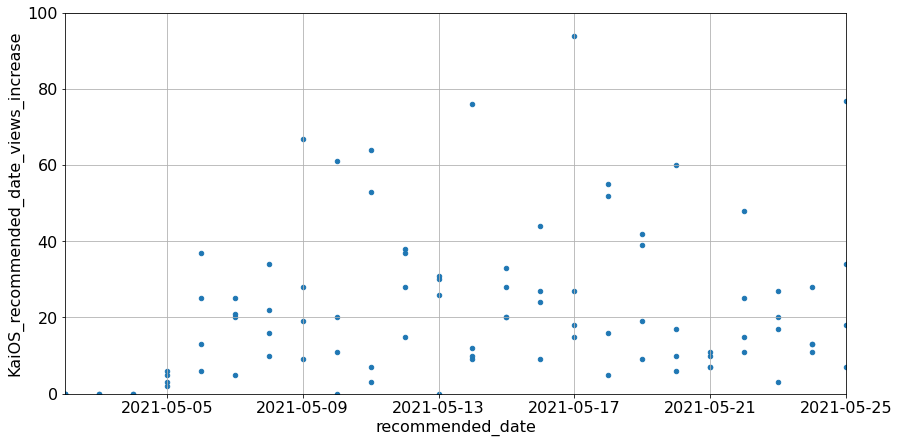

In [72]:
top_recommended_articles.plot(x="recommended_date", y="KaiOS_recommended_date_views_increase", kind="scatter", ylim=(0,100));